In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import tqdm

from matplotlib.animation import FFMpegWriter
from IPython.display import Video

seed = 0
random.seed(seed)
np.random.seed(seed)

# 1. Monte Carlo Integration

Calculate a value for the integral
\begin{equation}
    I=\int_0^1 \frac{x^{-1/2}}{e^x + 1} dx,
\end{equation}
using the importance sampling formula (Eq.10.42), with $w(x)=x^{1/2}$, as follows.

(a)	Show that the probability distribution $p(x)$ from which the sample points should be drawn is given by
\begin{equation}
    p(x)=\frac{1}{2\sqrt{x}},
\end{equation}
and derive a transformation formula for generating random numbers between zero and one from this distribution

The normalization factor is 
\begin{equation}
    Z=\int_0^1 x^{-1/2} dx = \left. 2x^{1/2}\right|_{0}^{1}=2
\end{equation}
Hence, let
\begin{equation}
    p(x) = \frac{1}{2\sqrt{x}}
\end{equation}
Then,
\begin{equation}
    I = 2\int_{0}^{1} \frac{1}{e^x + 1} p(x) dx = 2\mathbb E_{X\sim p(x)}\left[\frac{1}{e^X + 1}\right]\approx \frac{2}{N}\sum_{i=0}^{N-1} \frac{1}{1+e^{\tilde{x}_i}}
\end{equation}
Where $\{\tilde{x}_i\}$ are points sampled from the distribution $p(x)$.

Then the cumulative distribution function is
\begin{equation}
    C(x) = \int_{0}^{x} p(t) dt = \sqrt{x}
\end{equation}
and
\begin{equation}
    C^{-1}(x) = x^2.
\end{equation}
Therefore, if $u$ is following uniform distribution from $0$ to $1$, $x=C^{-1}(u)$ follows the probability distribution $p(x)$.
\begin{equation}
    P(a<C^{-1}(u)<b) = P(C(a)<u<C(b))=C(b)-C(a)=\int_{a}^{b}p(x)\, dx
\end{equation}

(b)	Using your formula, sample $N = 1,000,000$ random points and hence evaluate the integral. (Answer is around 0.84.) 

In [2]:
def sample(shape):
    uni = np.random.uniform(0, 1, shape)
    return uni ** 2

def f(x):
    return 1 / (1 + np.exp(x))

N = 1_000_000_000
batch_size = 10_000_000
n_batches = N // batch_size
remainder = N % batch_size

total = 0.0
for _ in tqdm.trange(n_batches):
    total += np.sum(f(sample((batch_size,))))
if remainder:
    total += np.sum(f(sample((remainder,))))

I = 2 * (total / N)
I.item()

100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


0.8389368470862997

# 2. The Ising model

The Ising model is a theoretical model of a magnet. The magnetization of a magnetic material is made up of the combination of many small magnetic dipoles spread throughout the material. If these dipoles point in random directions then the overall magnetization of the system will be close to zero. But if they line up so that all or most of them point in the same direction then the system can acquire a macroscopic magnetic moment-it becomes magnetized. The Ising model is a model of this process in which the individual moments are represented by dipoles or “spins” arranged on a grid or lattice:

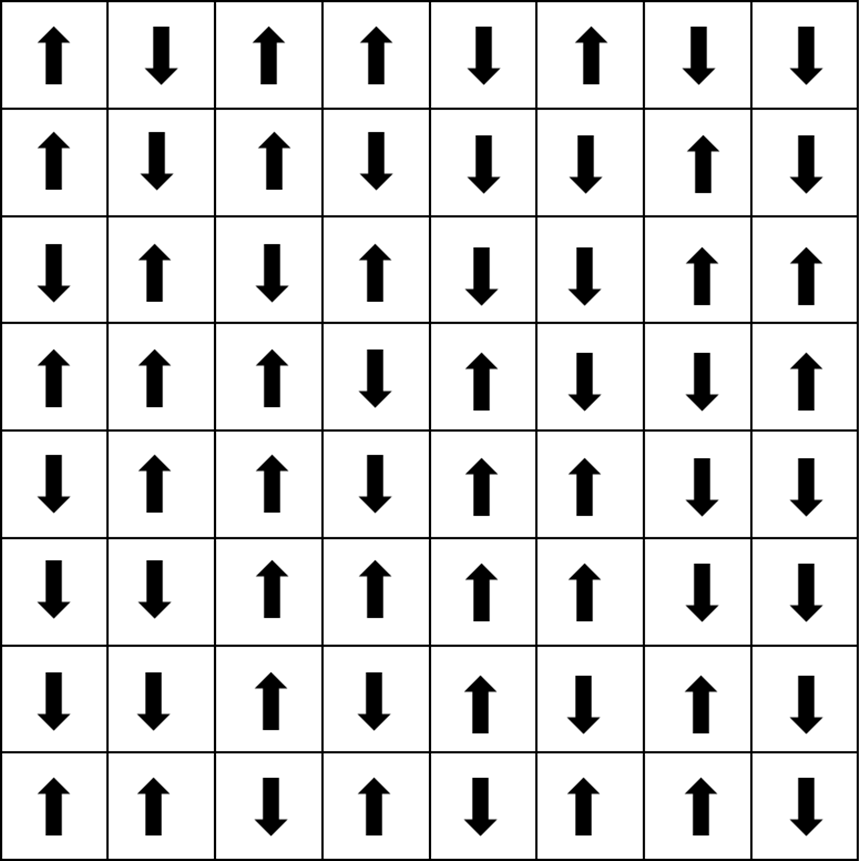

In this case we are using a square lattice in two dimensions, although the model can be defined in principle for any lattice in any number of dimensions. The spins themselves, in this simple model, are restricted to point in only two directions, up and down. Mathematically the spins are represented by variables, $s_j=\pm 1$ on the points of the lattice, $+1$ for up-pointing spins and $-1$ for down-pointing ones. Dipoles in real magnets can typically point in any spatial direction. The magnetic potential energy due to the interaction of two dipoles is proportional to their dot product, but in the Ising model this simplifies to just the product $s_i s_j$ for spins on sites $i$ and $j$ of the lattice, since the spins are one-dimensional scalars, not vectors. Then the actual energy of interaction is $-Js_i s_j$, where $J$ is a positive interaction constant. The minus sign ensures that the interaction are *ferromagnetic*, meaning the energy is lower when dipoles are lined up. A ferromagnetic interaction implies that the material will magnetize if given the chance. (In some materials the interaction has the opposite sign so that the dipoles prefer to be anti-aligned. Such a material is said to be *antiferromagnetic*, but we will not look at the case in here.)

Normally it is assumed that spins interact only with those that are immediately adjacent to them on the lattice, which gives a total energy for the entire system equal to 
\begin{equation}
    E = -J\sum_{\braket{i, j}} s_i s_j
\end{equation}
Where the notation $\braket{i, j}$ indicates a sum over pairs $i, j$ that are adjacent on the lattice. On the square lattice, each spin has four adjacent neighbors with which it interacts, except for the spins at the edges of the lattice, which have either two or three neighbors. Write a program to perform a Markov chain Monte Carlo simulation of the Ising model on the square lattice for a system of $20\times 20$ spins. You will need to set up variables to hold the value $\pm 1$ of the spin on each lattice site, probably using a two-dimensional integer array, and then take the following steps.

(a)	First write a function to calculate the total energy of the system, as given by the equation above. That is, for a given array of values of the spins, go through every pair of adjacent spins and add up the contributions $s_is_j$ from all of them, then multiply by $-J$.

In [3]:
def H_ising_PBC(x, J=1.0):
    dim = len(x.shape)
    E = 0.0
    for d in range(dim):
        shifted = np.roll(x, shift=1, axis=d)
        E += np.sum((-J) * x * shifted)
    return E

def H_ising_OBC(x, J=1.0):
    dim = len(x.shape)
    E = 0.0
    for d in range(dim):
        sl1 = [slice(None)] * dim
        sl2 = [slice(None)] * dim
        sl1[d] = slice(1, None)
        sl2[d] = slice(None, -1)
        E += np.sum((-J) * x[tuple(sl1)] * x[tuple(sl2)])
    return E

x = np.array([
    [-1,  1,  1], 
    [ 1, -1, -1], 
    [ 1,  1, -1]],
    dtype=np.float64
)
H_ising_PBC(x), H_ising_OBC(x) # 6, 2

(np.float64(6.0), np.float64(2.0))

(b)	Now use your function as the basis for a Metropolis-style simulation of the Ising model with $J=1$ and temperature $T=1$ in units where the Boltzmann constant $k_\mathrm{B}$ is also 1. Initially set the spin variables randomly to $\pm 1$, so that on average about a half of them are up and a half down, giving a total magnetization of roughly zero. Then choose a spin at random, flip it, and calculate the new energy after it is flipped, and hence also the change in energy as a result of the flip. Then decide whether to accept the flip using the Metropolis acceptance formula;
\begin{equation}
    P_\alpha = \begin{cases}
        1 & \text{if $E_j \le E_i$} \\
        e^{-\beta (E_j - E_i)} & \text{if $E_j > E_i$}
    \end{cases}
\end{equation}
If the move is rejected you will have to flip the spin back to where it was. Otherwise you keep the flipped spin. Now repeat this process for many moves.

In [ ]:
def mh_step(x, E_prev, beta, H, J=1.0):
    idx = tuple(np.random.randint(l) for l in x.shape)
    x[idx] *= -1
    E_new = H(x, J)
    dE = E_new - E_prev
    if dE < 0 or np.random.uniform(0, 1) < np.exp(-beta * dE):
        accepted = True
        return x, E_new, accepted
    else:
        x[idx] *= -1
        accepted = False
        return x, E_prev, accepted
    
def mh_simulation(x0, n_steps, beta, H, order_param, J=1.0, progress_bar=True):
    x = x0.copy()
    E = np.empty((n_steps,), dtype=np.float64)
    E[0] = H(x, J)
    P = np.empty((n_steps,), dtype=np.float64)
    P[0] = order_param(x)
    accepted_cnt = 0
    
    if progress_bar:
        pbar = tqdm.trange(1, n_steps)
    else:
        pbar = range(1, n_steps)
    
    for i in pbar:  
        x, E[i], accepted = mh_step(x, E[i-1], beta, H, J)
        P[i] = order_param(x)
        if accepted:
            accepted_cnt += 1
    return x, E, P, accepted_cnt / n_steps

(c)	Make a plot of the total magnetization $M=\sum_i s_i$ of the system as a function of time for a million Monte Carlo steps. You should see that the system develops a "spontaneous magnetization", a nonzero value of the overall magnetization.

100%|██████████| 999999/999999 [00:23<00:00, 42306.43it/s]


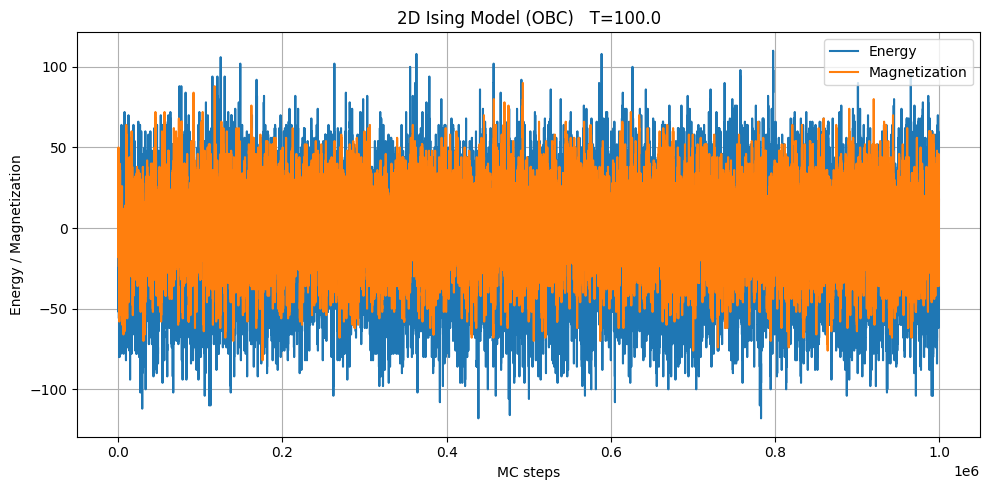

Converged energy: -8.24
Converged magnetization: -1.46


In [7]:
Nx = 20
Ny = 20
x0 = np.random.choice([-1., 1.], size=(Nx, Ny), replace=True)

k_B = 1.0
T = 100.0
beta = 1 / (k_B * T)
H = H_ising_OBC

n_steps = 1_000_000
x, E, M, acc = mh_simulation(x0, n_steps, beta, H, np.sum)

plt.figure(figsize=(10, 5))
plt.plot(E, label='Energy')
plt.plot(M, label='Magnetization')
plt.xlabel('MC steps')
plt.ylabel('Energy / Magnetization')
plt.title(f'2D Ising Model (OBC)   T={T}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Converged energy: {np.mean(E[-100_000:]):.2f}")
print(f"Converged magnetization: {np.mean(M[-100_000:]):.2f}")

(d)	Run your program several times and observe the sign of the magnetization that develops, positive or negative. Describe what you find and give a brief explanation of what is happening.

100%|██████████| 999999/999999 [00:32<00:00, 30791.89it/s]


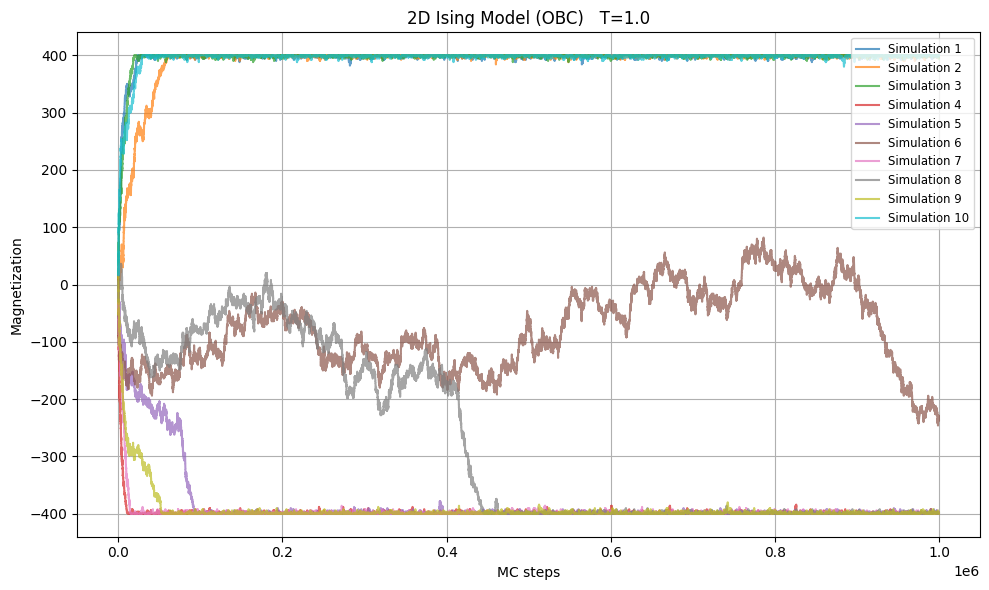

In [6]:
Nx, Ny = 20, 20
k_B = 1.0
T = 1.0
beta = 1 / (k_B * T)
n_steps = 1_000_000

plt.figure(figsize=(10, 6))

for i in range(10):
    x0 = np.random.choice([-1., 1.], size=(Nx, Ny), replace=True)
    x, E, M, acc = mh_simulation(x0, n_steps, beta, H_ising_OBC, np.sum)
    plt.plot(M, alpha=0.7, label=f'Simulation {i+1}')

plt.xlabel('MC steps')
plt.ylabel('Magnetization')
plt.title(f'2D Ising Model (OBC)   T={T}')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

At low temperatures, if J is positive, it is more preferable for neighboring spins to align in the same direction because it is less energetic, so the distribution converged to a distribution with some fluctuations with all spins aligned in the same direction. In addition, flipping all spins over has the same energy, so we can see that depending on the initial configuration and the subsequent sampled walks, there is a split between all up-spin aligned and all down-spin aligned.

(e)	Run the program with $T=1$, $T=2$, and $T=3$. How and why does the behaviour of the system change as temperature is increased?

100%|██████████| 999999/999999 [00:20<00:00, 49234.95it/s]


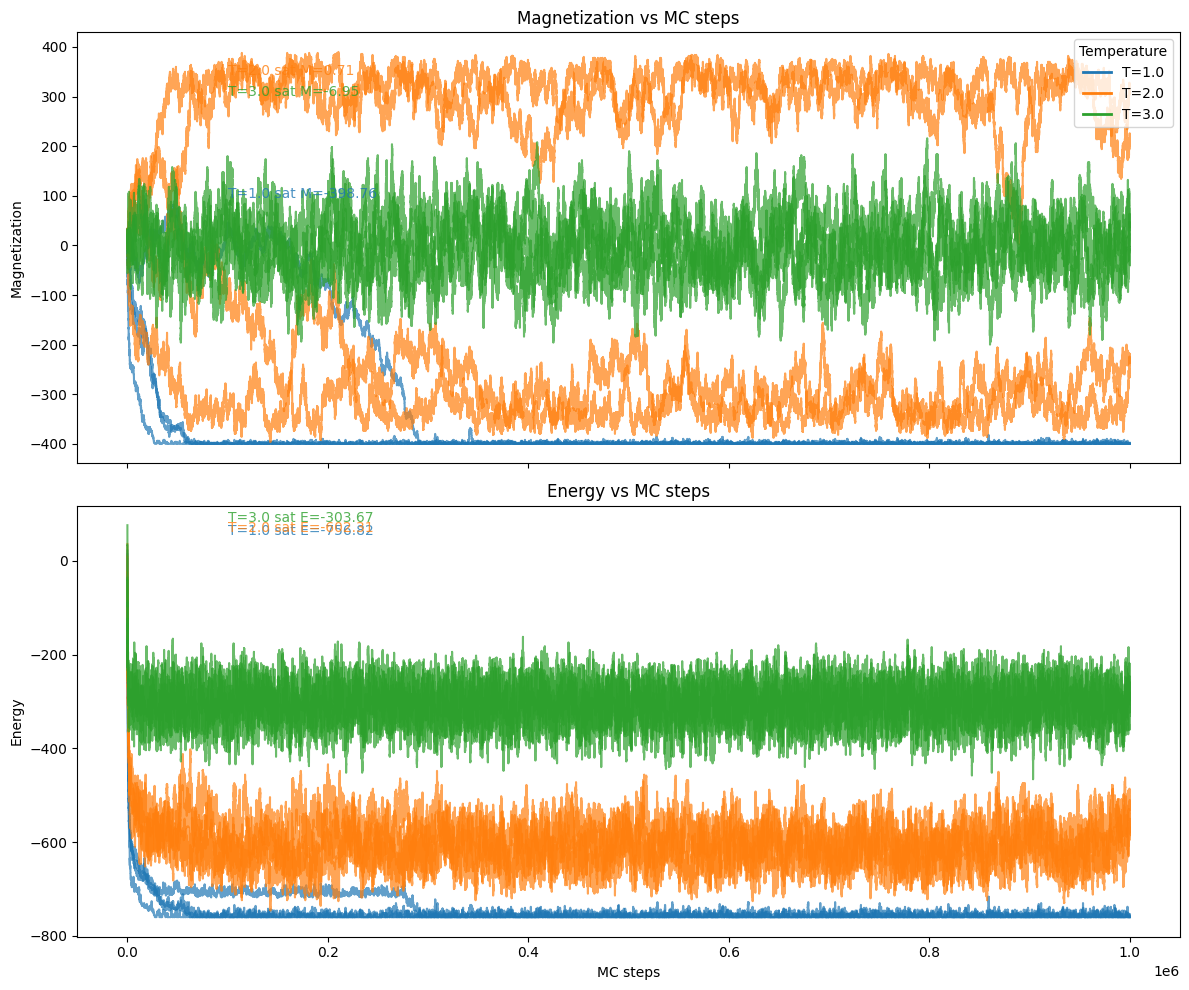

In [7]:
Nx, Ny = 20, 20
k_B = 1.0
n_steps = 1_000_000
temperatures = [1.0, 2.0, 3.0]
n_sim = 4

colors = plt.cm.tab10(np.arange(len(temperatures)))

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for idx, T in enumerate(temperatures):
    beta = 1 / (k_B * T)
    color = colors[idx]
    for i in range(n_sim):
        x0 = np.random.choice([-1., 1.], size=(Nx, Ny), replace=True)
        x, E, M, acc = mh_simulation(x0, n_steps, beta, H_ising_OBC, np.sum)
        
        axes[0].plot(M, alpha=0.7, color=color)
        axes[1].plot(E, alpha=0.7, color=color)

axes[0].set_ylabel('Magnetization')
axes[1].set_ylabel('Energy')
axes[1].set_xlabel('MC steps')
axes[0].set_title('Magnetization vs MC steps')
axes[1].set_title('Energy vs MC steps')

legend_lines = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(temperatures))]
legend_labels = [f'T={T}' for T in temperatures]
axes[0].legend(legend_lines, legend_labels, loc='upper right', title='Temperature')

plt.tight_layout()
plt.show()

As temperature increases, the fluctuation from the ground state increases and converged expected energy is deviated from -800, the lowest energy.

# 3. Brownian motion

Brownian motion is the motion of a particle, such as a smoke or dust particle, in a gas, as it is buffed by random collisions with gas molecules. Make a simple computer simulation of such a particle in two dimensions as follows: The particle is confined to a square grid or lattice $L\times L$ squares on a side, so that its position can be represented by two integers $i, j=0, ..., L-1$. It starts in the middle of the grid. On each step of the simulation, choose a random direction-up, down, left or right-and move the particle one step in that direction. This process is called a random walk. The particle is not allowed to move outside the limits of the lattice-if it tries to do so, choose a new random direction to move in. Write a program to perform a million steps of this process on a lattice with $L=101$ and make an animation on the screen of the position of the particle. (We choose an odd length for the side of the square so that there is one lattice site exactly in the center.)

In [ ]:
L = 101
n_steps = 1_000_000
mid = L // 2
p0 = np.array([mid, mid], dtype=np.int64)
trajectory = np.zeros((n_steps + 1, 2), dtype=np.int64)
trajectory[0] = p0

for i in tqdm.trange(1, n_steps + 1):
    x, y = trajectory[i - 1]
    choices = []
    if x > 0:
        choices.append([-1, 0])
    if x < L - 1:
        choices.append([1, 0])
    if y > 0:
        choices.append([0, -1])
    if y < L - 1:
        choices.append([0, 1])
    choices = np.array(choices)
    step = choices[np.random.choice(len(choices))]
    trajectory[i] = trajectory[i - 1] + step
    

sampling_rate = 11
max_frames = 600
reduced_trajectory = trajectory[::sampling_rate]
num_frames = min(max_frames, len(reduced_trajectory))
fps = 20
video_path = "./random_walk.mp4"

fig, ax = plt.subplots(figsize=(6, 6))
x, y = reduced_trajectory[0]
ax.scatter(x, y, s=5, c='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'step={0}')
ax.set_xlim(0, L - 1)
ax.set_ylim(0, L - 1)
ax.set_aspect('equal')
ax.grid(True)
ax.set_xticks(np.arange(0, L, 5))
ax.set_yticks(np.arange(0, L, 5))

def update(frame):
    step = frame * sampling_rate
    x, y = reduced_trajectory[frame]
    ax.clear()
    ax.set_xlim(0, L - 1)
    ax.set_ylim(0, L - 1)
    ax.scatter(x, y, s=5, c='blue')
    ax.set_title(f'step={step}')

writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
with writer.saving(fig, video_path, dpi=100):
    for frame in tqdm.trange(num_frames, desc="making video"):
        update(frame)
        writer.grab_frame()
plt.close(fig)

Video(video_path, embed=True)

making video: 100%|██████████| 600/600 [00:17<00:00, 34.25it/s]


# 4. Diffusion-limited aggregation (DLA)

You will develop a computer program to reproduce one of the most famous models in computational physics, diffusion-limited aggregation, or DLA for short. There are various versions of DLA, but the on we’ll study is as follows. You take a square grid with a single particle in the middle. The particle performs a random walk from square to square on the grid until it reaches a point on the edge of the system, at which point it “sticks” to the edge, becoming anchored there and immovable. Then a second particle starts at the center and does a random walk until it sticks either to an edge or to the other particle. Then a third particle starts, and so on. Each particle starts at the center and walks until it sticks either to an edge or to any anchored particle.

(a)	Make a copy of the Brownian motion program (Problem 3). This will serve as a starting point for your DLA program. Modify your program to perform the DLA process on a $101\times 101$ lattice. Repeatedly introduce a new particle at the center and have it walk randomly until sticks to an edge or an anchored particle.

Stuck at step 1889067


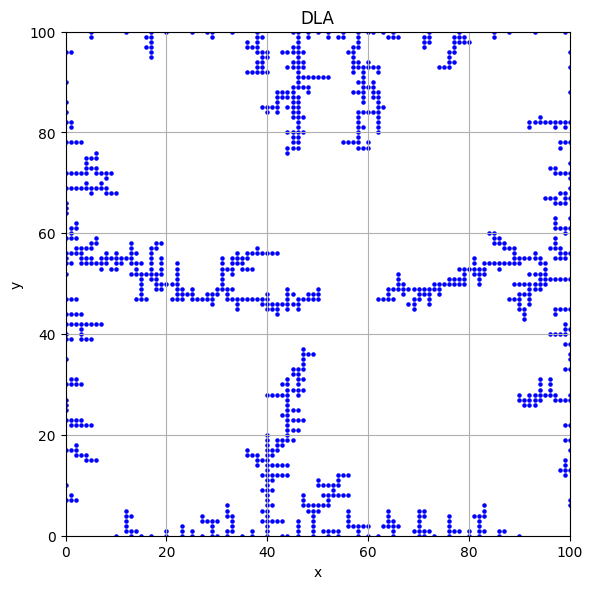

In [ ]:
L = 101
n_steps = 100_000_000
mid = L // 2
start = (mid, mid)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
steps = 0

def is_sticked(p, point_set):
    x, y = p
    if x == 0 or x == L - 1 or y == 0 or y == L - 1:
        return True
    for d in directions:
        dx, dy = d
        if (x + dx, y + dy) in point_set:
            return True
    return False



point_set = set()
while steps < n_steps:
    p = start
    if is_sticked(p, point_set):
        print(f"Stuck at step {steps}")
        break
    while not is_sticked(p, point_set):
        dp = random.choice(directions)
        p = (p[0] + dp[0], p[1] + dp[1])
        steps += 1
    point_set.add(p)
        
points = np.array(list(point_set))
x, y = points[:, 0], points[:, 1]
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=5, c='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('DLA Simulation')
plt.xlim(0, L - 1)
plt.ylim(0, L - 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [ ]:
L = 101
n_steps = 100000
sampling_rate = 100
mid = L // 2
start = (mid, mid)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
steps = 0
fps = 60
video_path = "./dla_a.mp4"

fig, ax = plt.subplots(figsize=(6, 6))
scat = ax.scatter([], [], s=5, c='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'DLA simulation step={0}')
ax.set_xlim(0, L - 1)
ax.set_ylim(0, L - 1)
ax.set_aspect('equal')

def is_sticked(p, point_set):
    x, y = p
    if x == 0 or x == L - 1 or y == 0 or y == L - 1:
        return True
    for d in directions:
        dx, dy = d
        if (x + dx, y + dy) in point_set:
            return True
    return False

writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
with writer.saving(fig, video_path, dpi=100):
    pbar = tqdm.tqdm(total=n_steps, desc="DLA Simulation & Writing Video")
    point_set = set()
    points = []
    while steps < n_steps:
        p = start
        if is_sticked(p, point_set):
            print(f"Stuck at step {steps}")
            break
        while not is_sticked(p, point_set):
            dp = random.choice(directions)
            p = (p[0] + dp[0], p[1] + dp[1])
            steps += 1
            pbar.update(1)
            if steps % sampling_rate == 0:
                point_arr = np.array(points + [p])
                scat.set_offsets(point_arr)
                ax.set_title(f'DLA simulation step={steps}')
                writer.grab_frame()
        point_set.add(p)
        points.append(p)
plt.close(fig)

Video(video_path, embed=True)

DLA Simulation & Writing Video: 100348it [01:16, 1303.91it/s]:00<?, ?it/s]
DLA Simulation & Writing Video: 101205it [00:16, 5849.35it/s]                           

(b)	In the interest of speed, change your program so that it shows only the anchored particles on the screen and not the randomly walking ones. That way you need to update the pictures on the screen only when a new particle becomes anchored. Set up the program so that it stops running once there is an anchored particle in the center of the grid, at the point where each particle starts its random walk. Once there is a particle at this point, there’s no point running any longer because any further particles added will be anchored the moment they start out. Run your program and see what it produces

In [ ]:
L = 101
n_steps = 2_000_000
sampling_rate = 1
mid = L // 2
start = (mid, mid)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
steps = 0
fps = 24
video_path = "./dla_b.mp4"

fig, ax = plt.subplots(figsize=(6, 6))
scat = ax.scatter([], [], s=5, c='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'DLA simulation step={0}')
ax.set_xlim(0, L - 1)
ax.set_ylim(0, L - 1)
ax.set_aspect('equal')

def is_sticked(p, point_set):
    x, y = p
    if x == 0 or x == L - 1 or y == 0 or y == L - 1:
        return True
    for d in directions:
        dx, dy = d
        if (x + dx, y + dy) in point_set:
            return True
    return False

writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
with writer.saving(fig, video_path, dpi=100):
    pbar = tqdm.tqdm(total=n_steps, desc="DLA Simulation & Writing Video")
    point_set = set()
    points = []
    while steps < n_steps:
        p = start
        if is_sticked(p, point_set):
            print(f"Stuck at step {steps}")
            break
        while not is_sticked(p, point_set):
            dp = random.choice(directions)
            p = (p[0] + dp[0], p[1] + dp[1])
            steps += 1
            pbar.update(1)
        point_set.add(p)
        points.append(p)
        
        if len(points) % sampling_rate == 0:
            point_arr = np.array(points)
            scat.set_offsets(point_arr)
            ax.set_title(f'DLA simulation step={steps}')
            writer.grab_frame()
plt.close(fig)

Video(video_path, embed=True)

DLA Simulation & Writing Video: 1000382it [01:18, 12767.56it/s] 0<?, ?it/s]


DLA Simulation & Writing Video:  38%|███▊      | 1530068/4000000 [00:14<00:48, 51444.74it/s] 

Stuck at step 1535030


DLA Simulation & Writing Video:  38%|███▊      | 1535030/4000000 [00:26<00:47, 51444.74it/s]

(c)	Try modifying it to use a $201\times 201$ lattice and run it again. See what it produces

In [ ]:
L = 201
n_steps = 50_000_000
sampling_rate = 4
mid = L // 2
start = (mid, mid)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
steps = 0
fps = 24
video_path = "./dla_c.mp4"

fig, ax = plt.subplots(figsize=(6, 6))
scat = ax.scatter([], [], s=2, c='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'DLA simulation step={0}')
ax.set_xlim(0, L - 1)
ax.set_ylim(0, L - 1)
ax.set_aspect('equal')

def is_sticked(p, point_set):
    x, y = p
    if x == 0 or x == L - 1 or y == 0 or y == L - 1:
        return True
    for d in directions:
        dx, dy = d
        if (x + dx, y + dy) in point_set:
            return True
    return False

writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
with writer.saving(fig, video_path, dpi=100):
    pbar = tqdm.tqdm(total=n_steps, desc="DLA Simulation & Writing Video")
    point_set = set()
    points = []
    while steps < n_steps:
        p = start
        if is_sticked(p, point_set):
            print(f"Stuck at step {steps}")
            break
        while not is_sticked(p, point_set):
            dp = random.choice(directions)
            p = (p[0] + dp[0], p[1] + dp[1])
            steps += 1
            pbar.update(1)
        point_set.add(p)
        points.append(p)
        
        if len(points) % sampling_rate == 0:
            point_arr = np.array(points)
            scat.set_offsets(point_arr)
            ax.set_title(f'DLA simulation step={steps}')
            writer.grab_frame()
plt.close(fig)

Video(video_path, embed=True)

DLA Simulation & Writing Video:   0%|          | 0/100000000 [00:00<?, ?it/s]

DLA Simulation & Writing Video:  25%|██▌       | 25237396/100000000 [00:39<04:05, 304670.60it/s]

Stuck at step 25268142


(d)	A nice further twist is to modify the program so that anchored particles are shown in different colors depending on their age, with the shades or colors changing gradually from the first particle added to the last.

DLA Simulation:  52%|█████▏    | 25815614/50000000 [00:30<00:34, 701630.59it/s]

Stuck at step 25833003


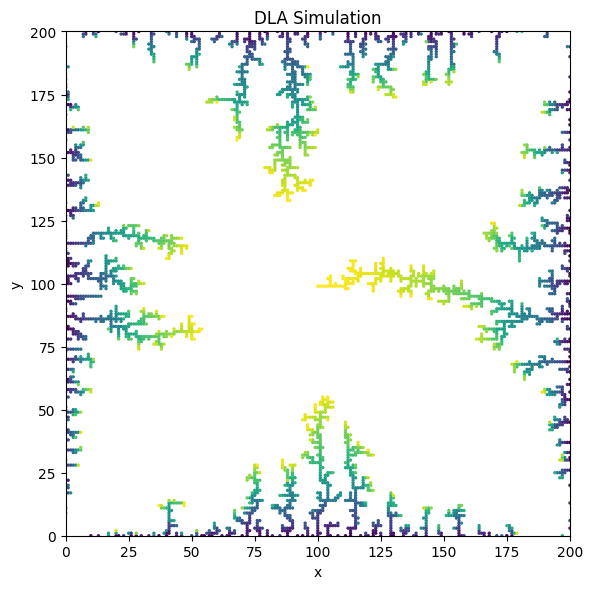

DLA Simulation:  52%|█████▏    | 25833003/50000000 [00:45<00:34, 701630.59it/s]

In [45]:
L = 201
n_steps = 50_000_000
mid = L // 2
start = (mid, mid)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
steps = 0

def is_sticked(p, point_set):
    x, y = p
    if x == 0 or x == L - 1 or y == 0 or y == L - 1:
        return True
    for d in directions:
        dx, dy = d
        if (x + dx, y + dy) in point_set:
            return True
    return False

pbar = tqdm.tqdm(total=n_steps, desc="DLA Simulation")
point_set = set()
points = []
while steps < n_steps:
    p = start
    if is_sticked(p, point_set):
        print(f"Stuck at step {steps}")
        break
    while not is_sticked(p, point_set):
        dp = random.choice(directions)
        p = (p[0] + dp[0], p[1] + dp[1])
        steps += 1
        pbar.update(1)
    point_set.add(p)
    points.append(p)
        
        
indices = np.arange(len(points))
point_arr = np.array(points)
x, y = point_arr[:, 0], point_arr[:, 1]
plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=2, c=indices, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('DLA Simulation')
plt.xlim(0, L - 1)
plt.ylim(0, L - 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()